# Phase 1 

### Preprocessing

In [1]:
import pandas as pd
import numpy as np
import os
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem import PorterStemmer

### Now load the pickle data into dataframes from the Output folder one directory above

In [2]:
def loadEverything():
    all_projects_bugreports = pd.read_pickle('Output/allBugReports.pickle')
    print("*** All Bug Reports are Loaded. ***")
    all_projects_source_codes = pd.read_pickle('Output/allSourceCodes.pickle')
    print("*** All Source Codes are Loaded. ***")
    return all_projects_bugreports, all_projects_source_codes

all_projects_bugreports, all_projects_source_codes = loadEverything()

*** All Bug Reports are Loaded. ***
*** All Source Codes are Loaded. ***


# Preprocessing
#### This section contains all the file for cleaning up the source files and bug reports

The main steps we took are:
- removing and cleaning up new lines or extra lines in the unprocessed code
- changing source file paths and bug fix file paths to be of the same format for comparison later 
- cleaning composite words that have a `camelCase` syntax 
- removing english stop words, java key words and java operators
- stemming & tokenizing 
- combing description and summary for bug report to create the query

#### Removing new lines

In [3]:
import re

#remove next line characters:
def remove_new_lines(text):
    text = str(text)
    COMBINE_WHITE_SPACE = re.compile(r"(?a:\s+)")
    text = COMBINE_WHITE_SPACE.sub(' ', text)
    return text.replace('*', '').replace('/', '').replace('\\','')
    
# clean up the various white space and remove some *
def clean_new_lines_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(remove_new_lines)
    return df

# clean up the description and summary, they will both be used for the query
def clean_new_lines_bug_report(df):
    df.summary = df.summary.apply(remove_new_lines)
    df['description'] = df['description'].astype('|S')
    df.description = df.description.apply(remove_new_lines)
    return df

#### Cleaning file paths

In [ ]:
# changes file path to be just the filename + extension for source code files
def clean_sc_file(x):
    file = x.split("\\")
    return ''.join(file[-1:])

# changes file path to be just the filename + extension for bug report fixes 
def clean_bug_file(x):
    fixes = []
    for file in x:
        file = file.split(".")
        file = '.'.join(file[-2:])
        fixes.append(file)
    return fixes


def clean_sc_filepath(df):
    df.filename = df.filename.apply(clean_sc_file)
    return df


def clean_bug_filepath(df):
    df.fix = df.fix.apply(clean_bug_file)
    return df

#### Cleaning composite words

In [4]:
#splitting composite words
#splits using camlecase syntax
def findCompositeWords(s):
    return ' '.join(re.findall('[A-Z][^A-Z]*', s))   


def clean_composite_source_code(df):
    df.unprocessed_code = df.unprocessed_code.apply(findCompositeWords)
    return df

def clean_composite_bug_report(df):
    df.summary = df.summary.apply(findCompositeWords)
    df.description = df.description.apply(findCompositeWords)
    return df


#### Combining stop words, keywords and operators

In [5]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# add the Java key words to the stop words
java_keywords = ["abstract", "assert**","assert", "boolean", "break", "byte", "case", "catch", "char", "const", "continue", "default", "do", "double", "else", "enum", "enum****" "extends", "final", "finally", "for", "goto","goto*", "if", "implements", "import", "instanceof", "int","interface", "long", "native", "new", "package", "private", "protected", "public", "return", "short", "static", "strictfp**","strictfp", "super", "switch", "synchornized", "this", "throw", "throws", "transient", "try", "void", "volatile", "while"]
java_operators = ["+", "-", "*", "/", "%", "+=", "-=", "*=", "/=", "++", "--", "==", "!=", "<", ">", "<=", ">=", ".", "[", "]", "(",")", "!", "~","instanceof", "<<", ">>", ">>>", "&", "^", "|", "&&", "||", "?", ":", "^=", "%=", "<<=", ">>=", ">>>=", "&="]
stop = java_keywords + java_operators
#contains english stop words, java keywords and java operators
STOP_WORDS = ENGLISH_STOP_WORDS.union(stop)



#### Stemming & calling cleaning functions

In [6]:
# remove the stem and stop words
# takes in an array of strings returns an array of strings
def stem_stop(text):
    stemmer = PorterStemmer()   #"english"
    text = text.split()
    text = [w for w in text if not w in STOP_WORDS]
    text = list(map(lambda x: stemmer.stem(x), text))
    text = ' '.join(text)
    text = text.strip()
    return text

# clean up the unprocessed code column
def clean_source_df(df):
    # clean up the new lines
    df = clean_new_lines_source_code(df)
    # clean up composite words
    df = clean_composite_source_code(df)
    # clean filepaths
    df = clean_sc_filepath(df)
    return df

# add the summary and description together and clean the data
def clean_combine_bug_df(df):
    # clean up new lines
    df = clean_new_lines_bug_report(df)
    # clean composite words
    df = clean_composite_bug_report(df)
    # clean file path
    df = clean_bug_filepath(df)
    # combine summary and descriptions to create query
    df["query"] = df["summary"] + df["description"]
    return df


# TF-IDF
### This section contains all the code for applying two different cosine similarity functions

In this sections we apply two different similarity functions, equation (1) and equations(7) from the report. 
The TF-IDF is fitted to each of the 12 projects and used to calculate the similarity.


For equation (1):
- we used a classic VSM, and found the relevancy score between a file f and a query q as being the cosine similarity between their corresponding vector representations 

For equation (7):
- we used a rVSM, where the relevancy score is calculated between each source code file and the bug report (direct relevancy)
- this is favourable to the classic VSM model as it takes into account the length of files, and does not favour shorter files like equation 1
- we used the file lengths as the number for terms in equations 5


In [9]:
from sklearn.metrics.pairwise import cosine_similarity

# generate number of terms based off of length of file 
def generate_number_terms(arr):
    result = []
    for item in arr:
        result.append( 1 / (1 + np.exp(-1 * item)))
    return result

# min max scaler 
def custom_min_max(arr):
    min_val = min(arr)
    max_val = max(arr)
    result = []
    for item in arr:
        result.append((item - min_val)/(max_val - min_val))
        
    return result

# calculate the similarity when using revised Vector Space Model
def calculate_similarity_eq7(src_files, src_vect, query, num_terms):
    cosSim = cosine_similarity(query, src_vect).flatten()
    for i in range(len(cosSim)):
        cosSim[i] = cosSim[i] * num_terms[i]
    return cosSim

# calculate the similarity when using basic cosine similarity   
def calculate_similarity(src_vect, query):
    cosSim = cosine_similarity(query, src_vect).flatten()
    return cosSim

# fit the vectorizer and transform data
def get_similarity(vect, src_files, src_vect, query_data, num_terms):
    query = vect.transform(query_data)
    similarity = calculate_similarity(src_vect,query)  
    similarity_eq7 = calculate_similarity_eq7(src_files, src_vect, query, num_terms)


    return similarity, similarity_eq7



## Ranking similarities and getting fix indexes to compare 

In this section we rank the files and determine whether the fix was found or not and if it was, which index it was. 

In [18]:
# rank all the similarity scores
def rank_sim_scores(scores):
    sim_scores = list()
    
    for score in scores:
        indicies = range(len(score))

        scores_tuple = tuple(zip(score,indicies))
        sorted_tuple = sorted(scores_tuple, reverse = True)

        sim_scores.append(sorted_tuple)
    
    return sim_scores

# look through the src data frame to find where the fix is. 
def get_fix_indexes(bug, src):
    fix_list = list()
    for fixes in bug["fix"]:
        fix_sub=list()
        for fix in fixes:
            df = src[src["filename"].str.match(fix)]
            if(df.shape[0] != 0):
                fix_sub.append(df.index[0])
            else:
                fix_sub.append(-1)
        fix_list.append(fix_sub)
    # this is a list of the indexes of the file where the fix was located
    return fix_list

# MAP & MRR

## insert info 

In [19]:
def average_precision(bug,n=10,isCosineSim=True):
#checks precision for the top n values. If n is too large then this score loses meaning
    ap_list = list()
    ranked_sim = 'ranked_sim'
    if not isCosineSim:
        ranked_sim = 'ranked_eq7_sim'
    for index, row in bug.iterrows():
        countTrue = 0
        for i in range(len(row[ranked_sim])):
            if i >= n:
                break
            # check if source file is actually where bug is located
            if(row[ranked_sim][i][1] in row['fix_indexes']):
                countTrue+=1
        ap_list.append(countTrue/n)
    return ap_list


def reciprocal_rank(bug,isCosineSim=True):
#reciprocal rank is 1/n, where n is the first position of a source file where the bug is located in the ranked_sim column
    rr_list = list()
    ranked_sim = 'ranked_sim'
    if not isCosineSim:
        ranked_sim = 'ranked_eq7_sim'
    for index, row in bug.iterrows():
        rr = 0
        for i in range(len(row[ranked_sim])):
            # check if source file is actually where bug is located
            if(row[ranked_sim][i][1] in row['fix_indexes']):
                rr = 1/(i+1)
                break
        rr_list.append(rr)
    return rr_list

### Get metrics into the data frames

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
# take in the source code df for a project and a single query return scores


def generate_scores_list(source, query):
    scores_list = [] 
    scores_list_eq7 = []
    # get a list of strings from the data frames to be vectorized
    source['unprocessed_code'] = source['unprocessed_code'].map(stem_stop)
    query["query"] = query["query"].map(stem_stop)


    
    # fit a vectorizer to the data
    vect = TfidfVectorizer(min_df=1).fit(source['unprocessed_code'])
    src_vect = vect.transform(source['unprocessed_code'])
    
    source['unprocessed_code']
    source_lengths = []
    for src in source['unprocessed_code']:
        source_lengths.append(len(src.split()))
    
    # normalized length used to calculated normalized num of terms
    normalized_source_length = custom_min_max(source_lengths)

    # normalized num of terms
    num_terms = generate_number_terms(normalized_source_length)

    
    #get the similarity scores for the bug reports    
    for q in query["query"]:
        similarity, similarity_eq7 = get_similarity(vect,source['unprocessed_code'], src_vect, [q], num_terms)
        scores_list.append(similarity)
        scores_list_eq7.append(similarity_eq7)

    return scores_list, scores_list_eq7



def generate_all_scores():
    
    all_bugs = []
    all_src = []
    # iterate through the list of 12 projects
    i = 0
    for proj in projects:
       
        # create dataframes for each project
        src_df = sc_grouped_df.get_group(proj)
        bug_df = bg_grouped_df.get_group(proj).copy()
        
        # generate the scores list
        scores, scores_eq7 = generate_scores_list(src_df, bug_df)

        #append scores list to the bug dataframe
        bug_df["sim_vect"] = scores # the only way that the matrix is related to the src code 
                                    # is through the index.
        bug_df["sim_eq7_vect"] = scores_eq7
        # Rank the source code files and know what file(s) the bug was in
        bug_df["ranked_sim"] = rank_sim_scores(scores)
        bug_df["ranked_eq7_sim"] = rank_sim_scores(scores_eq7)
   
        # get list of where the fixes rank
        bug_df["fix_indexes"] = get_fix_indexes(bug_df, src_df)
        
        
        # Calculate the AP and RR for Cosine Similarity here
        bug_df["average_precision_1"] = average_precision(bug_df,1,True)
        bug_df["average_precision_5"] = average_precision(bug_df,5,True)
        bug_df["average_precision_10"] = average_precision(bug_df,10,True)

        bug_df["reciprocal_rank"] = reciprocal_rank(bug_df,True)
        
        # Calculate the AP and RR for rVSM here
        bug_df["average_precision_eq7_1"] = average_precision(bug_df,1,False)
        bug_df["average_precision_eq7_5"] = average_precision(bug_df,5,False)
        bug_df["average_precision_eq7_10"] = average_precision(bug_df,10,False)

        bug_df["reciprocal_rank_eq7"] = reciprocal_rank(bug_df,False)



        # maintain a list of all the dataframes
        all_bugs.append(bug_df)
        all_src.append(src_df)
    # concatenate all the data frames in order    
    all_bug_df = pd.concat(all_bugs, ignore_index=True)
    all_src_df = pd.concat(all_src, ignore_index=True)
    return all_bug_df, all_src_df

In [12]:
#  get clean versions of the dataframes
sc_df = clean_source_df(all_projects_source_codes)
br_df = clean_combine_bug_df(all_projects_bugreports)


# get a list of the projects 
projects = sc_df.project.unique()

# group the data frames
sc_grouped_df = sc_df.groupby(sc_df.project)
bg_grouped_df = br_df.groupby(br_df.project)


In [13]:
bugs, sources = generate_all_scores()

<ipython-input-11-2bc86b837114>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['unprocessed_code'] = source['unprocessed_code'].map(stem_stop)
<ipython-input-11-2bc86b837114>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  source['unprocessed_code'] = source['unprocessed_code'].map(stem_stop)
<ipython-input-11-2bc86b837114>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [17]:
# adding missing file data to bugs df
noFix = []
totalMissing = []
someMissing = []
totalFixes = []

for indexes in bugs.fix_indexes:
    # checks whether all the fixes were not found
    notFound = all(i==-1 for i in indexes)
    if notFound:
        noFix.append(1)
    else:
        noFix.append(0)
    numMissing = 0
    numTotal = 0
    for i in indexes:
        # count total number of bug fixes
        numTotal = numTotal+1
        if i==-1:
            # count number of missing fixes
            numMissing = numMissing+1
    # checks whether at least one fix is missing
    if(numMissing >= 1):
        someMissing.append(1)
    else:
        someMissing.append(0)
    totalMissing.append(numMissing)
    totalFixes.append(numTotal) 
    
# bugs where all fixes were missing
bugs['no fix found'] = noFix
# total number of fixes missing
bugs['num fixes missing'] = totalMissing
# bugs where one or more fix is missing
bugs['some fixes missing'] = someMissing
# total number of bug fixes
bugs['total bug fix files'] = totalFixes

bugs

,fix,text,fixdate,summary,description,project,average_precision,query,sim_vect,sim_eq7_vect,...,average_precision_10,reciprocal_rank,average_precision_eq7_1,average_precision_eq7_5,average_precision_eq7_10,reciprocal_rank_eq7,no fix found,num fixes missing,some fixes missing,total bug fix files
0,"[flat3map.java, testflat3map.java]",NaN,2006-07-18 22:02:11,Flat3 Map. Entry.set Value() overwrites other ...,Flat3 Map&amp;apos;s Entry objects will overw...,COLLECTIONS,0.0,flat3 map. entry.set value() overwrit entri va...,"[0.058548134080555064, 0.08970216513375899, 0....","[0.030178088157363395, 0.04678957427468671, 0....",...,0.1,0.500000,1.0,0.2,0.1,1.000000,0,0,0,2
1,"[testextendedproperties.java, extendedproperti...",NaN,2006-07-18 22:44:33,Extended Properties - field include should be ...,"The field ""include"" in Extended Properties is...",COLLECTIONS,0.0,extend properti field includ non-stat privatet...,"[0.013388795565578315, 0.028400683146419893, 0...","[0.006901129459446437, 0.014814089175548205, 0...",...,0.1,0.500000,0.0,0.2,0.1,0.500000,0,0,0,2
2,"[testlistutils.java, testcollectionutils.java,...",NaN,2006-08-18 19:01:22,Collection Utils remove All is actually retain...,"The remove All( Collection collection, Collec...",COLLECTIONS,0.0,collect util remov all actual retain allth rem...,"[0.04851850840676917, 0.16573102168998424, 0.0...","[0.025008411402978322, 0.08644700980650988, 0....",...,0.3,1.000000,1.0,0.4,0.3,1.000000,0,0,0,3
3,"[flat3map.java, testflat3map.java]",NaN,2007-08-20 14:11:54,Flat3 Map.remove() does not return the correct...,Flat3 Map m = new Flat3 Map();n m.put( new I...,COLLECTIONS,0.0,flat3 map.remove() doe correct valu size 3flat...,"[0.03731537102786185, 0.046074298711050336, 0....","[0.01923385901511659, 0.024032829291023076, 6....",...,0.1,0.500000,0.0,0.2,0.1,0.500000,0,0,0,2
4,[fasttreemap.java],NaN,2007-08-31 09:39:59,Fast Tree Map forgets the comparator,In line 359 and 582 of the current 3.2 release...,COLLECTIONS,0.0,fast tree map forget comparatorin line 359 582...,"[0.016509059582201484, 0.016813266781609673, 0...","[0.008509440365449782, 0.008769973318984952, 0...",...,0.1,0.500000,1.0,0.2,0.1,1.000000,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1853,[legacypropertiessecurityrealmtest.java],NaN,2016-11-02 09:35:48,Add tests for special chars in Legacy Propert...,Add tests for issue https:issues.jboss.orgbrow...,ELY,0.0,add test special char legaci properti secur re...,"[0.0, 0.0, 0.007836449023673328, 0.0, 0.028303...","[0.0, 0.0, 0.003972016178443079, 0.0, 0.014215...",...,0.0,0.000000,0.0,0.0,0.0,0.000000,1,1,1,1
1854,"[legacypropertiessecurityrealm.java, legacypro...",NaN,2016-11-02 09:36:13,Elytron properties-realm is not compatible wit...,When users properties file (e.g. mgmt-users.pr...,ELY,0.0,elytron properties-realm compat legaci user pr...,"[0.08537209236074056, 0.07580328239533322, 0.0...","[0.042785377476829194, 0.038010418491644764, 0...",...,0.0,0.000000,0.0,0.0,0.0,0.000000,1,2,1,2
1855,"[serverauthenticationcontext.java, x500attribu...",NaN,2016-11-03 15:03:29,No log messages comming from Elytron - permis...,Elytron is missing any log messages related to...,ELY,0.0,No log messag com elytron permiss assignmentel...,"[0.017658409645957666, 0.01567919182991187, 0....","[0.008849750561932072, 0.00786209546913259, 0....",...,0.1,0.333333,0.0,0.2,0.1,0.333333,0,6,1,7
1856,"[sslauthenticationtest.java, digestutiltest.java]",NaN,2016-11-21 09:24:47,Don&apos;t use String to Upper Caseto Lower C...,The String.to Upper Case() and String.to Low...,ELY,0.0,don&apos;t use string upper caseto lower case ...,"[0.08509286693216991, 0.09785558900392012, 0.0...","[0.04264543988092205, 0.04906821673482553, 0.0...",...,0.0,0.000000,0.0,0.0,0.0,0.000000,1,2,1,2


## Calculate and graph MRR and MAP (Overall)

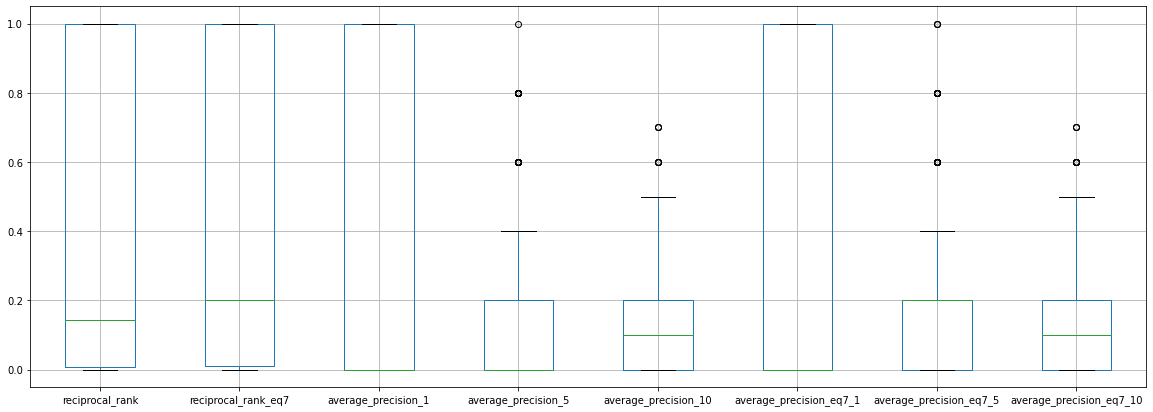

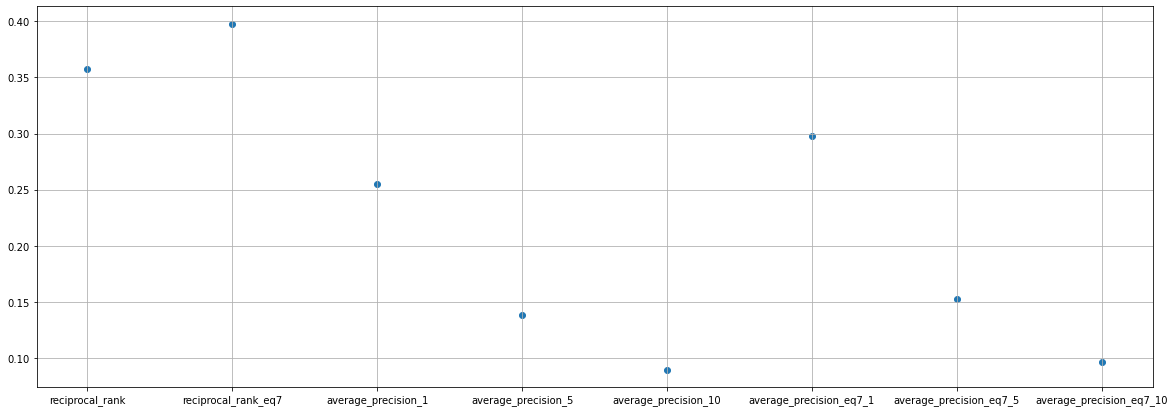

In [212]:
import matplotlib.pyplot as plt
def generate_graphs(bugs):
    important_cols = ["reciprocal_rank","reciprocal_rank_eq7","average_precision_1","average_precision_5","average_precision_10","average_precision_eq7_1","average_precision_eq7_5","average_precision_eq7_10"]
    boxplot = bugs.boxplot(column=important_cols,figsize=(20,7))
    mean_list = list()
    for col in important_cols:
        mean_list.append(bugs[col].mean())
    fig, ax = plt.subplots(figsize=(20,7))
    ax.grid()
    ax.scatter(important_cols,mean_list)
generate_graphs(bugs)

### Generating performance tables

In [259]:
# Creates 2 tables for performance, one for cosine similarity and one for rVSM
def performanceTable(bugs):
    data = []
    data_eq7 = []
    important_cols = ["reciprocal_rank","average_precision_1","average_precision_5","average_precision_10"]
    for proj in projects:
        bug_df = bugs.groupby(bugs.project).get_group(proj).copy()
        perf_list = list()
        perf_list_eq7 = list()
        
        perf_list.append(bug_df['reciprocal_rank'].mean())

        perf_list.append(bug_df['average_precision_10'].mean())
        
        perf_list.append(len(bug_df[(bug_df['average_precision_1']!=0)]))
        perf_list.append(100 * len(bug_df[(bug_df['average_precision_1']!=0)])/(len(bug_df)))

        perf_list.append(len(bug_df[(bug_df['average_precision_5']!=0)]))
        perf_list.append(100 * len(bug_df[(bug_df['average_precision_5']!=0)])/(len(bug_df)))

        perf_list.append(len(bug_df[(bug_df['average_precision_10']!=0)]))
        perf_list.append(100 * len(bug_df[(bug_df['average_precision_10']!=0)])/(len(bug_df)))
        
        perf_list.append(bug_df['no fix found'].sum())
        perf_list.append(bug_df['some fixes missing'].sum())
        perf_list.append(bug_df['total bug fix files'].sum())
        
        perf_list_eq7.append(bug_df['reciprocal_rank_eq7'].mean())

        perf_list_eq7.append(bug_df['average_precision_eq7_10'].mean())
        
        perf_list_eq7.append(len(bug_df[(bug_df['average_precision_eq7_1']!=0)]))
        perf_list_eq7.append(100 * len(bug_df[(bug_df['average_precision_eq7_1']!=0)])/(len(bug_df)))

        perf_list_eq7.append(len(bug_df[(bug_df['average_precision_eq7_5']!=0)]))
        perf_list_eq7.append(100 * len(bug_df[(bug_df['average_precision_eq7_5']!=0)])/(len(bug_df)))

        perf_list_eq7.append(len(bug_df[(bug_df['average_precision_eq7_10']!=0)]))
        perf_list_eq7.append(100 * len(bug_df[(bug_df['average_precision_eq7_10']!=0)])/(len(bug_df)))
        
        perf_list_eq7.append(bug_df['no fix found'].sum())
        perf_list_eq7.append(bug_df['some fixes missing'].sum())
        perf_list_eq7.append(bug_df['total bug fix files'].sum())

        perf_list.append(len(bug_df))
        perf_list_eq7.append(len(bug_df))
        

        data.append(perf_list)
        data_eq7.append(perf_list_eq7)
    df = pd.DataFrame(data,columns=["MRR","MAP (j=10)","Top 1 (Count)","Top 1 (%)","Top 5 (Count)","Top 5 (%)","Top 10 (Count)","Top 10 (%)","Bugs w/ No Fixes Found", "Bugs w/ Some Fixes Missing","Num of Bug Fix Files","Total Count"])
    df_eq7 = pd.DataFrame(data_eq7 ,columns=["MRR","MAP (j=10)","Top 1 (Count)","Top 1 (%)","Top 5 (Count)","Top 5 (%)","Top 10 (Count)","Top 10 (%)","Bugs w/ No Fixes Found", "Bugs w/ Some Fixes Missing","Num of Bug Fix Files", "Total Count"])
    df['PROJECT'] = projects
    df_eq7['PROJECT'] = projects
    
    df = df.set_index(['PROJECT'])
    df_eq7 = df_eq7.set_index(['PROJECT'])
    
    return df,df_eq7

performance_df,performance_df_eq7 = performanceTable(bugs)


### Performance Per Project using the cosine similarity

In [18]:
performance_df

,MRR,MAP (j=10),Top 1 (Count),Top 1 (%),Top 5 (Count),Top 5 (%),Top 10 (Count),Top 10 (%),Total Count
PROJECT,,,,,,,,,
COLLECTIONS,0.424600,0.101087,32,34.782609,46,50.000000,48,52.173913,92
CONFIGURATION,0.472454,0.121805,48,36.090226,84,63.157895,99,74.436090,133
IO,0.536720,0.105495,42,46.153846,60,65.934066,62,68.131868,91
LANG,0.503349,0.120276,82,37.788018,146,67.281106,152,70.046083,217
DATACMNS,0.443838,0.128481,51,32.278481,97,61.392405,108,68.354430,158
DATAMONGO,0.302186,0.081181,51,18.819188,112,41.328413,143,52.767528,271
DATAREST,0.400030,0.108333,37,28.030303,69,52.272727,81,61.363636,132
LDAP,0.415503,0.116981,14,26.415094,34,64.150943,36,67.924528,53
SEC,0.266030,0.063401,97,17.929760,190,35.120148,237,43.807763,541


### Performance Per Project using rVSM (revised vector space model)

In [19]:
performance_df_eq7

,MRR,MAP (j=10),Top 1 (Count),Top 1 (%),Top 5 (Count),Top 5 (%),Top 10 (Count),Top 10 (%),Total Count
PROJECT,,,,,,,,,
COLLECTIONS,0.433804,0.104348,34,36.956522,48,52.173913,48,52.173913,92
CONFIGURATION,0.513484,0.130075,51,38.345865,89,66.917293,103,77.443609,133
IO,0.585377,0.104396,47,51.648352,62,68.131868,62,68.131868,91
LANG,0.541238,0.120276,95,43.778802,145,66.820276,152,70.046083,217
DATACMNS,0.494659,0.134177,58,36.708861,102,64.556962,111,70.253165,158
DATAMONGO,0.383184,0.099631,73,26.937269,139,51.291513,170,62.730627,271
DATAREST,0.452209,0.121212,45,34.090909,75,56.818182,87,65.909091,132
LDAP,0.487266,0.124528,19,35.849057,35,66.037736,39,73.584906,53
SEC,0.290227,0.067098,110,20.332717,207,38.262477,243,44.916821,541


### Some more Graphs

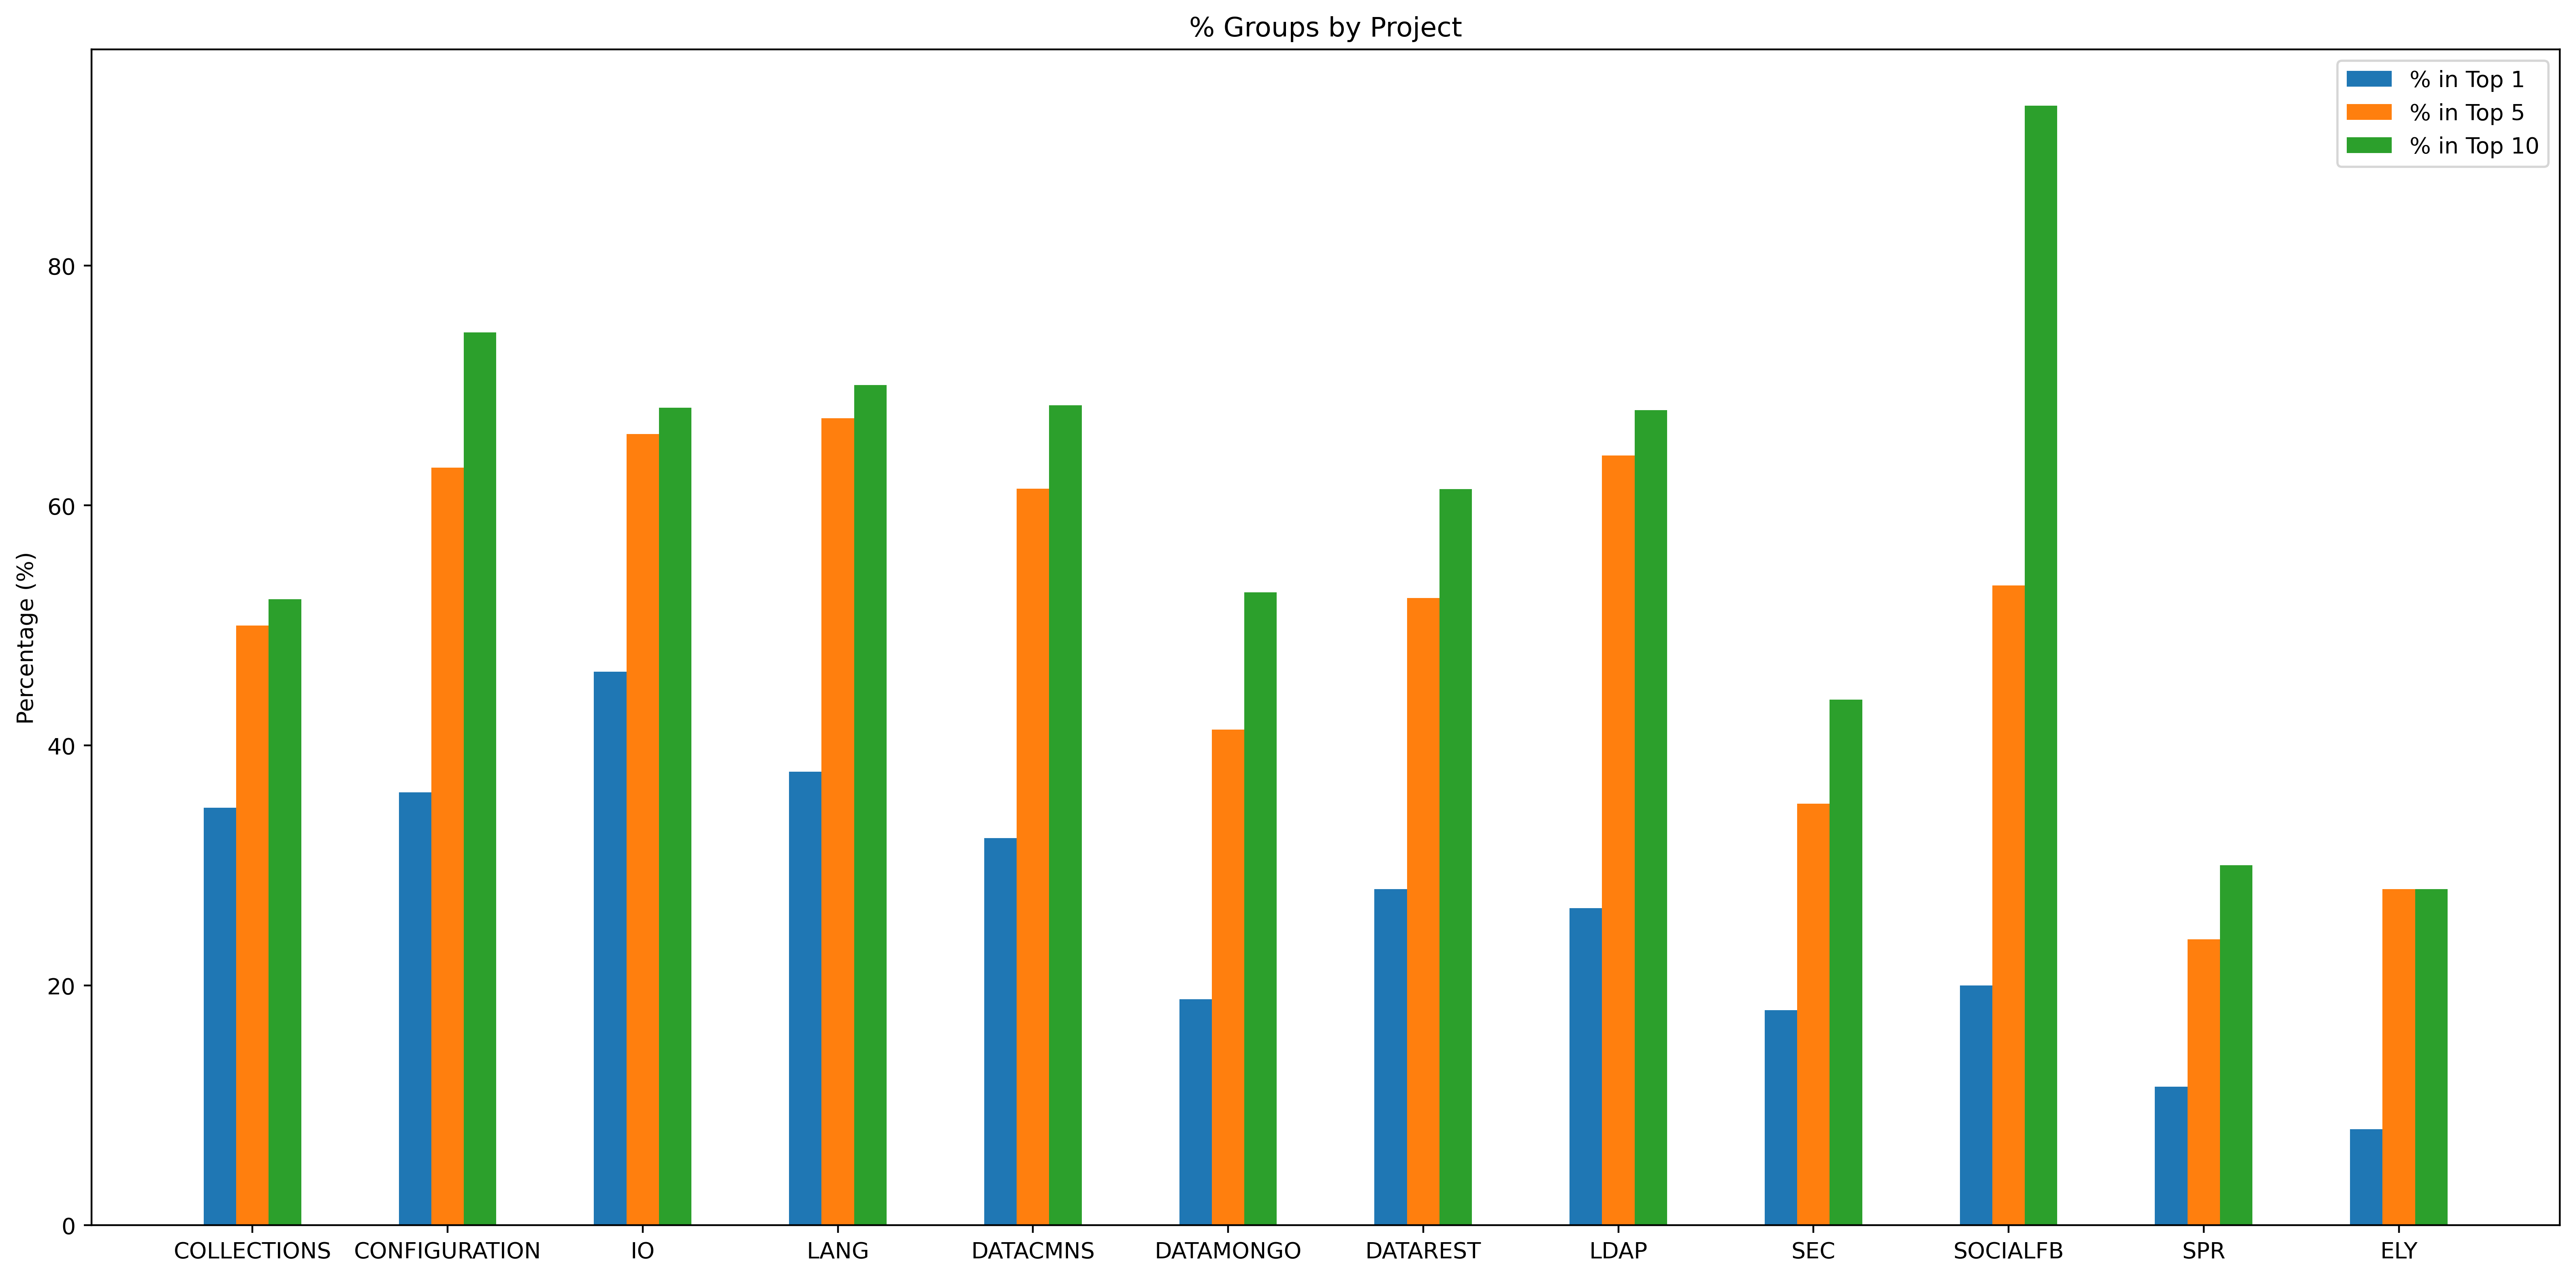

In [217]:

%matplotlib inline
import matplotlib.pyplot as plt
def generate_bar_chart(df):
    
    bars = ["% in Top 1", "% in Top 5", "% in Top 10"]
    # projects is a list of all the projects
    
    
    width = 0.5
    x = np.arange(len(projects))
    fig, ax = plt.subplots()
    rect1 = ax.bar(x - width*1/3, df["Top 1 (%)"], width/3, label='% in Top 1')
    rect2 = ax.bar(x , df["Top 5 (%)"], width/3, label='% in Top 5')
    rect3 = ax.bar(x + width*1/3, df["Top 10 (%)"], width/3, label='% in Top 10')
    
    ax.set_ylabel("Percentage (%)")
    ax.set_title('% Groups by Project')
    ax.set_xticks(x)
    ax.set_xticklabels(projects)
    ax.legend()
    
#     autolabel(rect1, ax)
#     autolabel(rect2, ax)
#     autolabel(rect3, ax)
    fig.tight_layout()
    plt.show()
    
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 400

generate_bar_chart(performance_df)


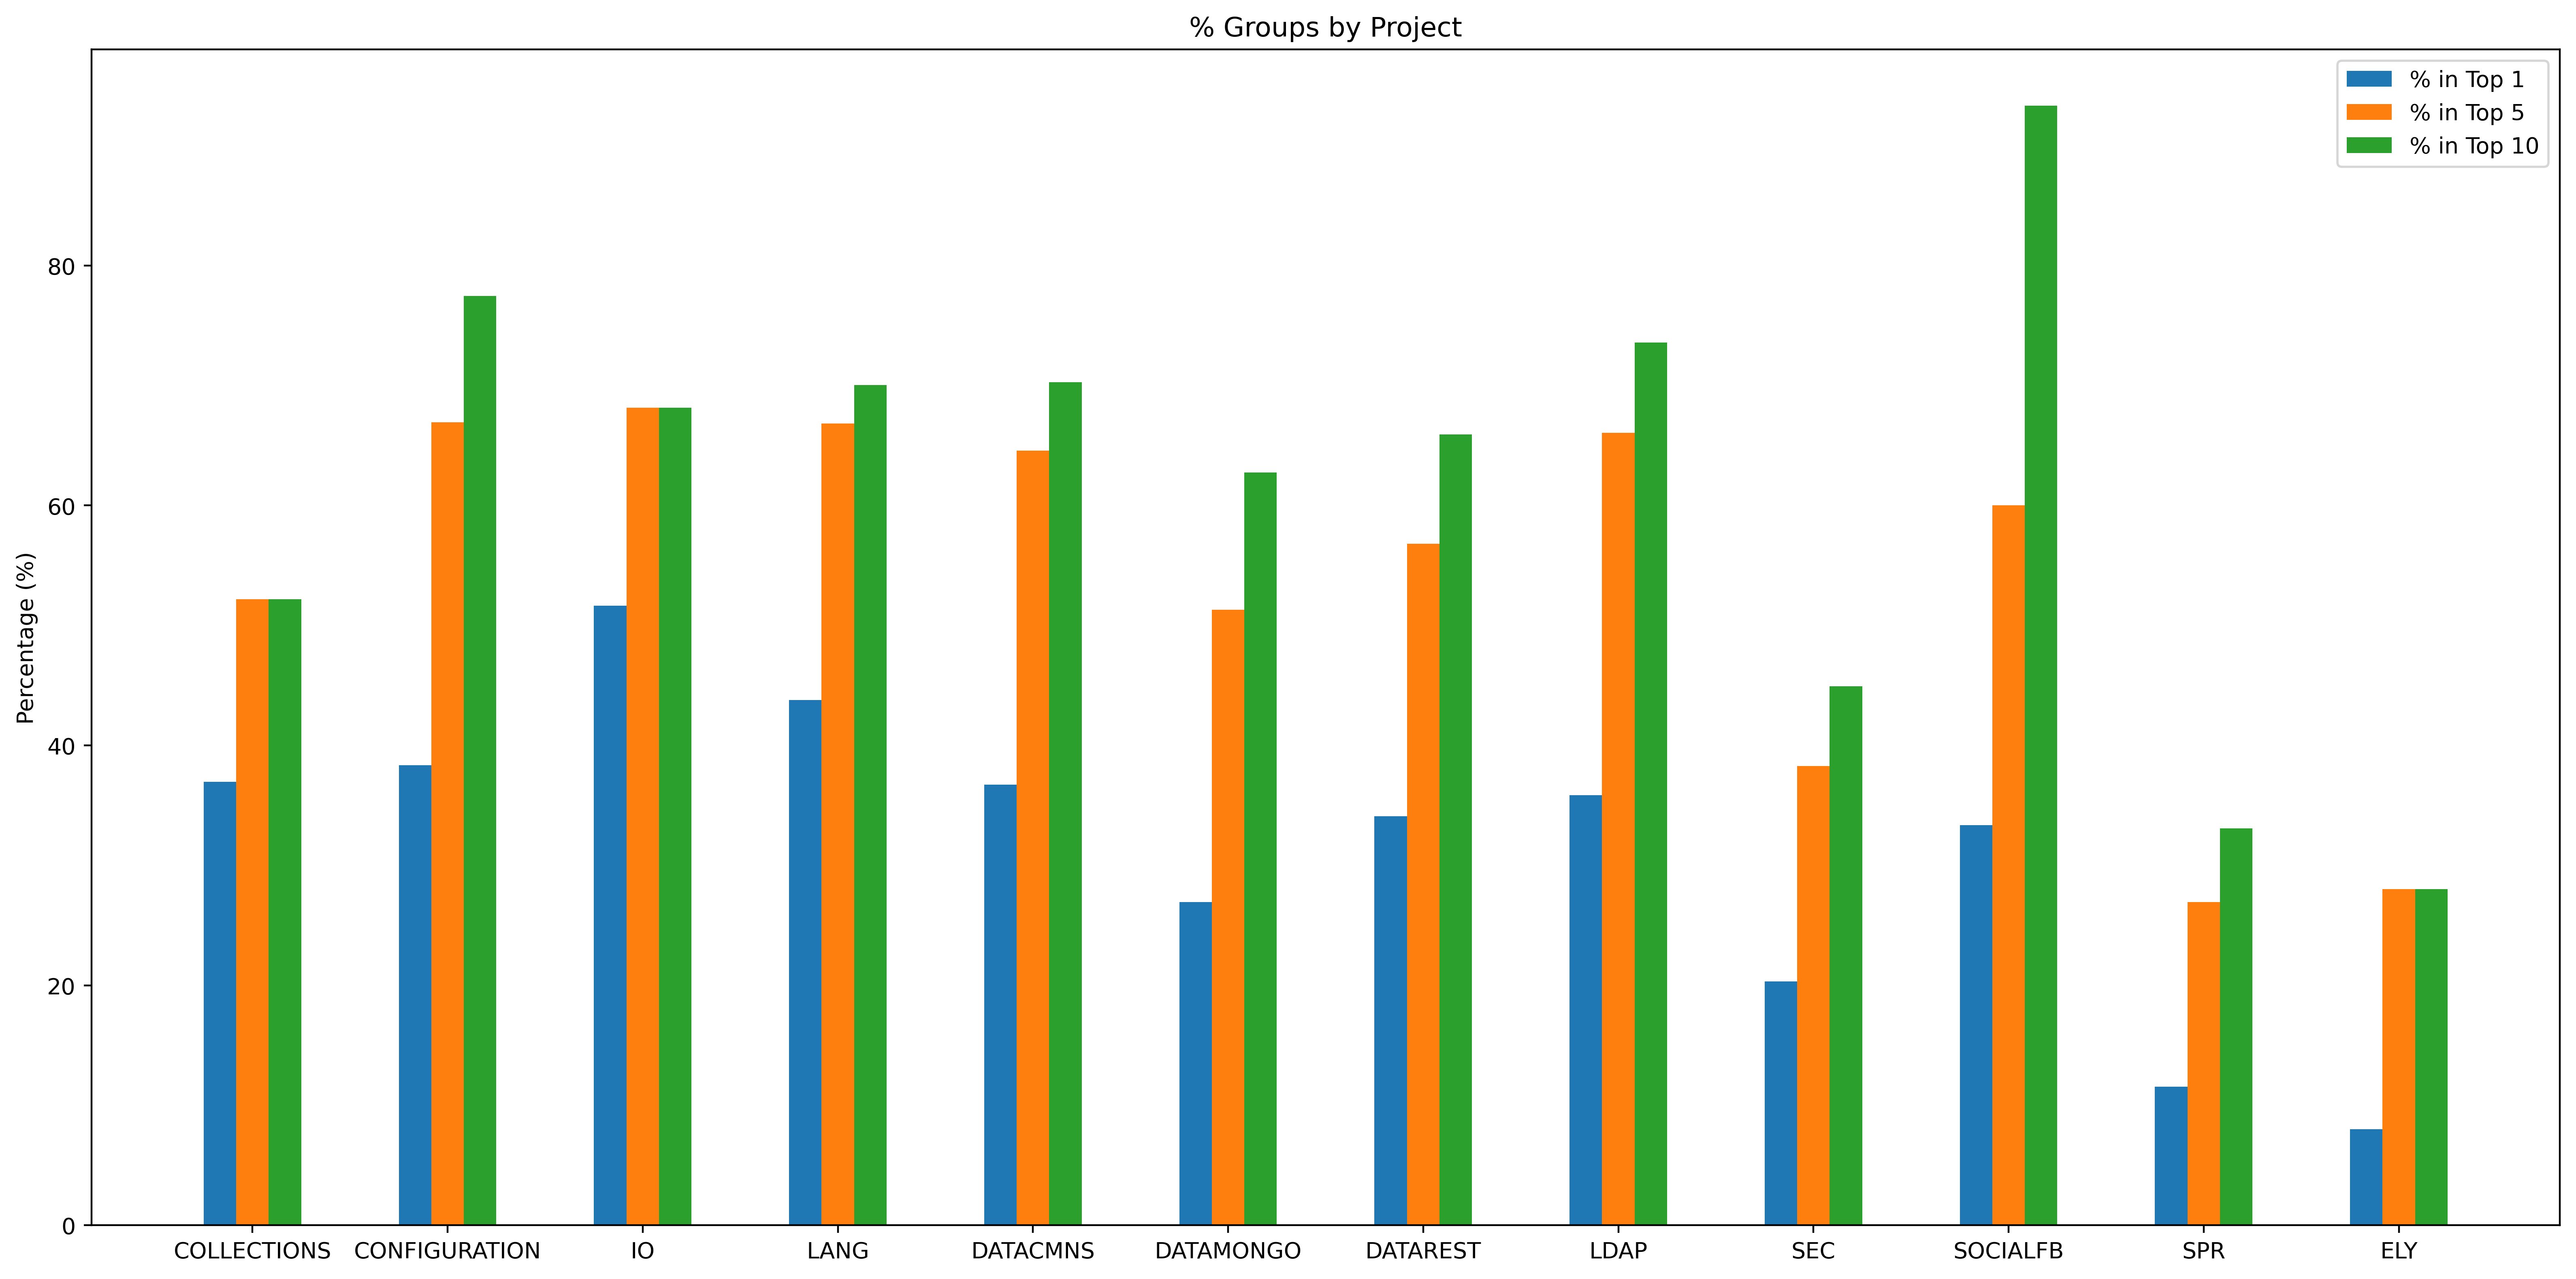

In [21]:
generate_bar_chart(performance_df_eq7)

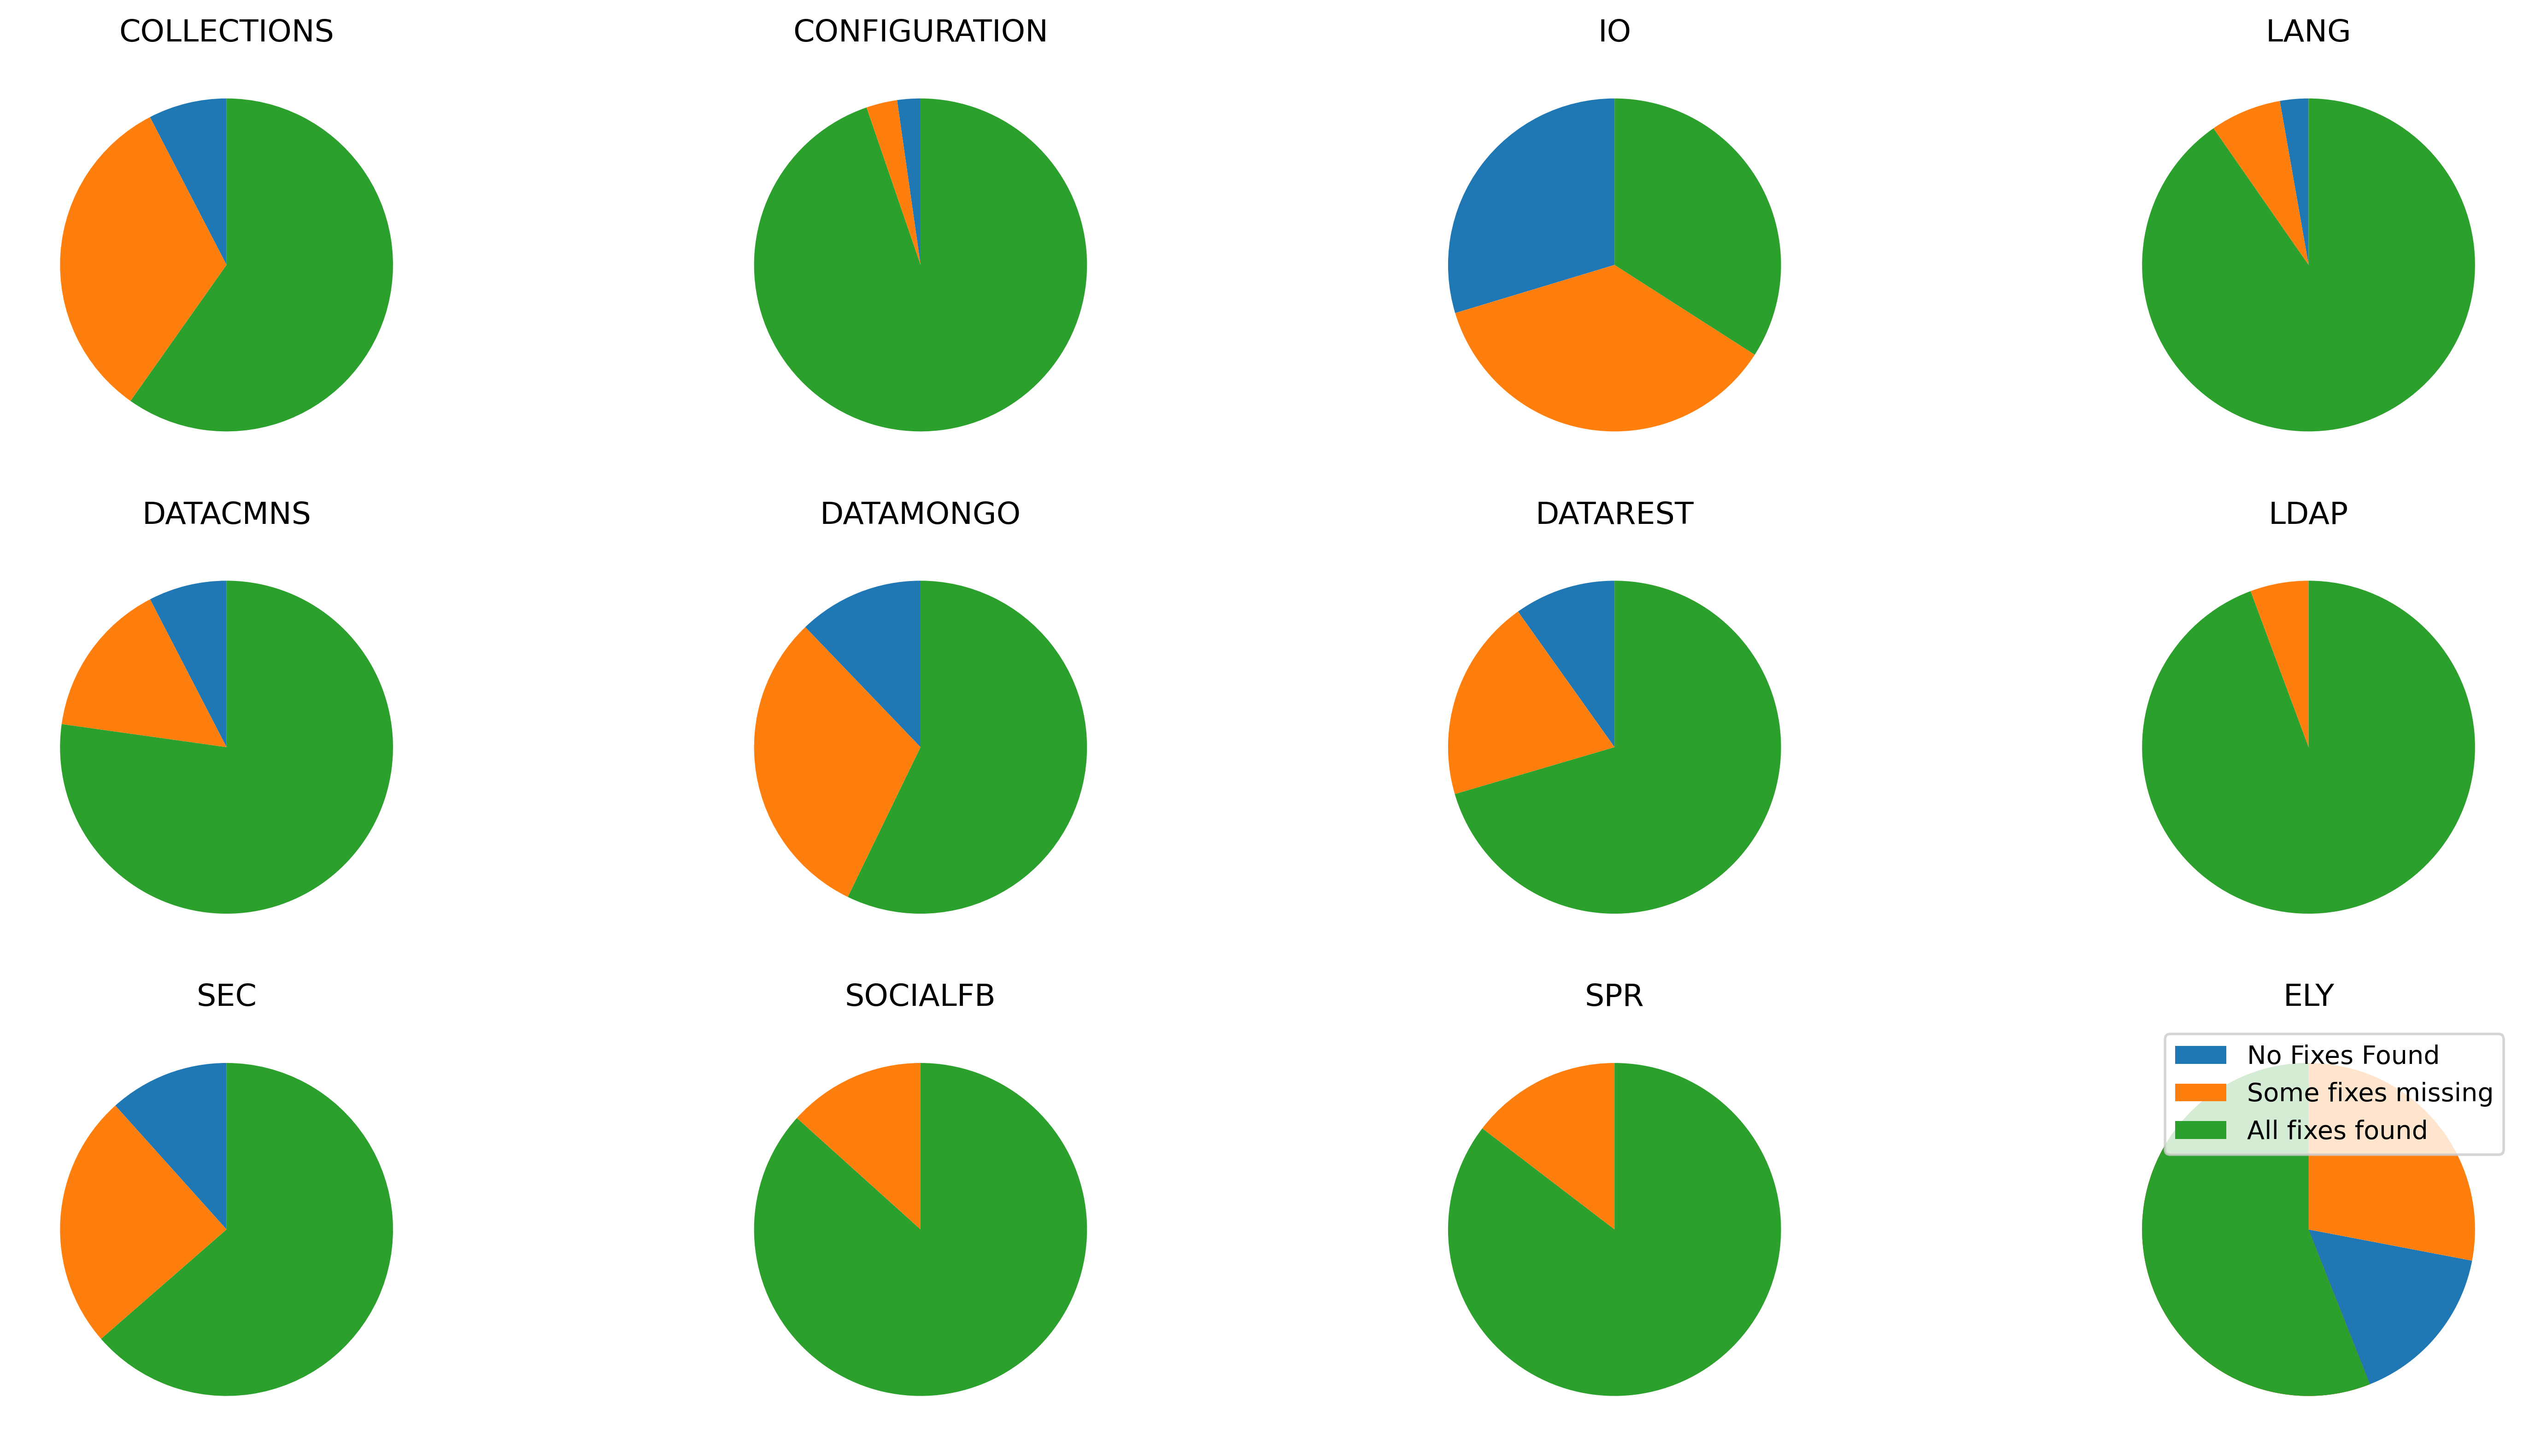

In [265]:
import matplotlib.pyplot as plt
import numpy as np; np.random.seed(1)

def project_pie_charts(df):
    projects = df.index.tolist()
    none = df['Bugs w/ No Fixes Found'].tolist()
    some = df['Bugs w/ Some Fixes Missing'].tolist()
    total = df['Total Count'].tolist()

    fig, axes= plt.subplots(3, 4)

    for i, ax in enumerate(axes.flatten()):
        labels = 'No Fixes Found', 'Some fixes missing', 'All fixes found'
        sizes = [none[i], some[i], (total[i] - (none[i] + some[i]))]
        ax.pie(sizes, pctdistance=0.9,startangle=90)
 
        ax.set_title(projects[i])
    plt.legend(labels)
    plt.tight_layout()
    plt.show()
    
project_pie_charts(performance_df)